# Optical Recognition of Handwritten Digits
## El problema
Tenemos un problema de clasificación con 10 clases. Los datos vienen de una universidad de Turquía que procesaron dígitos escritos a mano como mapas de bits.
## El data set
Los mapas de bits tienen 32 x 32 bits. Por suerte, los datos no son 32 x 32 columnas de booleanos. En cambio, estos investigadores, dividieron todo el mapa de bits en 64 cuadros de 4x4 bits e hicieron de cada cuadro una columna. Por tanto, cada uno de esos atributos, contiene la cuenta de bits "true" que hay en ese cuadro, por lo tanto, están entre 0 y 16. Es así como consiguieron reducir las dimensiones del problema.
## Elementos
- X: 64 columnas, cada una tiene un número entre 0 y 16 que representa la cuenta de bits activos en un cuadro del mapa.
- Y: La etiqueta tiene como rango 0-9 (que son todos los dígitos que contempla el sistema numérico decimal).
- Función objetivo: Dados los bits que contiene cada uno de los cuadros del mapa, predecir de que dígito se trata.
## Archivo de datos
En este caso no tenemos ni si quiera que hacer nosotros la separación entre datos de entrenamiento / test. Tenemos dos archivos CSV sin cabecera: 
- optdigits.tra: Datos de training.
- optdigits.tes: Datos de test.

## Datos perdidos
Según el fichero "optdigits.name", que da información sobre el data set, no hay datos perdidos. Vamos sin embargo a comprobar rápidamente que no hay datos perdidos y que hemos hecho correctamente la lectura.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Leemos los CSV con header=None para que no cuente la primera línea como cabecera
raw_data_training = pd.read_csv('./datos/optdigits.tra', header=None)
raw_data_test = pd.read_csv('./datos/optdigits.tes', header=None)

# Miramos a ver si hay algún dato perdido
print('Hay datos nulos en training:',raw_data_training.isna().any().any())
print('Hay datos nulos en test: ', raw_data_test.isna().any().any())

Hay datos nulos en training: False
Hay datos nulos en test:  False


## Muestreo estratificado
Podemos ver que tanto los datos de training como los de entrenamiento están estratificados por dígitos. Es decir, hay un equilibrio de ocurrencias de cada dígito. De esta forma, no hay falta de información sobre ninguno de ellos.

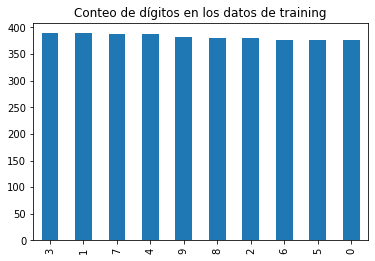

In [2]:
pd.value_counts(raw_data_training[64]).plot.bar(title="Conteo de dígitos en los datos de training")


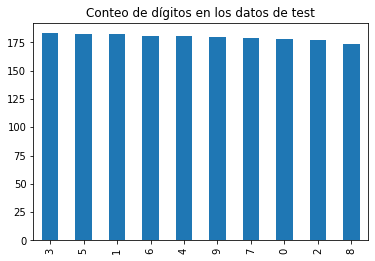

In [3]:
pd.value_counts(raw_data_test[64]).plot.bar(title="Conteo de dígitos en los datos de test")

In [4]:
# Partimos los datos en X Y, siendo 64 la columna que contiene la etiqueta o target

X_train = raw_data_training.drop(64, axis=1)
Y_train = raw_data_training[64]

print('X_train shape:', X_train.shape, 'Y_train shape:', Y_train.shape)

X_test = raw_data_test.drop(64, axis=1)
Y_test = raw_data_test[64]

print('X_test shape:', X_test.shape, 'Y_test shape:', Y_test.shape)


X_train shape: (3823, 64) Y_train shape: (3823,)
X_test shape: (1797, 64) Y_test shape: (1797,)


## Validación cruzada
En este caso tenemos una validación cruzada un poco más sofisticada que en el caso de regresión:
- Utilizamos "StratifiedKFold" para que parta los datos de training en 10 partes estratificadas, con aproximadamente la misma cantidad de ocurrencias de cada dígito.
- Utilizamos pipeline para encadenar también un StandardScaler que estandariza el rango de las columnas a una distribución Gaussiana con media 0 y varianza 1. 
z = (x - u) / s  (Siendo u la media de la columna y s la desviación tipica) Para cada dato (x).
- Utilizamos como métrica la precisión (porcentaje de aciertos)

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Utilizamos cross_val_score de sklearn que hace la validación cruzada por nosotros.
# Devuelve el valor de cada validación (en este caso 10)

def validate_models(model_strings, models, X_train, Y_train):
    validation_results = {'accuracy':[], 'std_dev_error': []}
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for model in models:
        pipeline = make_pipeline(StandardScaler(), model)
        results = cross_val_score(pipeline, X_train, Y_train, scoring = "accuracy", cv=cv)
        
        # Hacemos la media y desviación típica de las 10 validaciones
        
        validation_results['accuracy'].append(np.mean(np.abs(results)))
        validation_results['std_dev_error'].append(np.std(np.abs(results)))
        
        # Devolvemos una tabla con los modelos y sus métricas
        
    return pd.DataFrame(data=validation_results, index=model_strings)

## Regresión logística
A diferencia de la regresión logística que hemos trabajado en otras prácticas, en esta contamos con regularización por normal l2, minimizando la siguiente función:
$\min_{w, c} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1)$
Además, controlamos la regularización con el parámetro C (valores más pequeños, mas regularización).

In [6]:
from sklearn.linear_model import LogisticRegression
models = [
    LogisticRegression(multi_class='multinomial', C=0.5),
    LogisticRegression(multi_class='multinomial', C=1.0),
    LogisticRegression(multi_class='multinomial', C=1.5),
]

model_strings = [
    'Logistic Regression C = 0.5',
    'Logistic Regression C = 1.0',
    'Logistic Regression C = 1.5',
]

validate_models(model_strings, models, X_train, Y_train)

,accuracy,std_dev_error
Logistic Regression C = 0.5,0.973318,0.010844
Logistic Regression C = 1.0,0.974104,0.010693
Logistic Regression C = 1.5,0.973057,0.010668


## Perceptron
Un viejo conocido, en este caso también tiene opción de regularización. He probado, como se puede ver más abajo, con y sin ella (norma l2).


In [7]:
from sklearn.linear_model import Perceptron
models = [
    Perceptron(random_state=1),
    Perceptron(alpha=0.0001, penalty='l2',random_state=1),
    Perceptron(alpha=0.00025, penalty='l2',random_state=1),
    Perceptron(alpha=0.0004, penalty='l2',random_state=1),
    
]

model_strings = [
    'Perceptron sin regularización',
    'Perceptron alpha = 0.0001',
    'Perceptron alpha = 0.00025',
    'Perceptron alpha = 0.0004',
  
]

validate_models(model_strings, models, X_train, Y_train)

,accuracy,std_dev_error
Perceptron sin regularización,0.950039,0.008639
Perceptron alpha = 0.0001,0.938268,0.007688
Perceptron alpha = 0.00025,0.925184,0.016293
Perceptron alpha = 0.0004,0.916817,0.008671


## Ridge Classifier
Se optimiza la misma función que hemos visto para el problema de regresión. Se menciona en la documentación que puede ser más rápido para problemas multiclases (como este) ya que solo se computa la matriz de proyección una vez. $(X^T X)^{-1} X^T$
De nuevo, he probado con y sin regularización. Utilizo como algoritmo el de la descomposición en valores singulares, al igual que OLS.

In [8]:
from sklearn.linear_model import RidgeClassifier
models = [
    RidgeClassifier(alpha=0, solver='svd'),
    RidgeClassifier(alpha=1.0, solver='svd')
    
]

model_strings = [
    'Ridge alpha = 0',
    'Ridge alpha = 1.0',
]

validate_models(model_strings, models, X_train, Y_train)

,accuracy,std_dev_error
Ridge alpha = 0,0.933298,0.014812
Ridge alpha = 1.0,0.933036,0.014051


In [9]:
stdScaler = StandardScaler()
stdScaler.fit(X_train)
X_train_scaled = stdScaler.transform(X_train)
final_model = LogisticRegression(multi_class='multinomial', C=1.5)
final_model.fit(X_train_scaled, Y_train)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
from sklearn.metrics import accuracy_score
stdScaler = StandardScaler()
stdScaler.fit(X_test)
X_test_scaled = stdScaler.transform(X_test)
predictions = final_model.predict(X_test_scaled)
Etest = accuracy_score(Y_test, predictions)
print('Etest: ', Etest)

Etest:  0.9510294936004452
